In [1]:
import scipy
import scipy.stats.stats as stats
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

import sklearn
from factor_analyzer import FactorAnalyzer

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os, csv
import math
import time
import pickle
import gc
import sys
sys.version_info


sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)

## read data
 - pre -> 前測 , post -> 後測 

In [2]:
pre_atti = pd.read_csv('SC_analysis/language_pretest_attitude.csv').set_index('編號')
pre_atti.columns = ['college', 'gender', '優美[C]','優美[T]', '優美[E]','親切[C]', '親切[T]','親切[E]', 
                    '知識[C]','知識[T]', '知識[E]','趣味[C]', '趣味[T]','趣味[E]', '領導[C]','領導[T]', '領導[E]',
                    '信任[C]', '信任[T]','信任[E]', '一樣好','幼稚園', '大學修課[T]','大學修課[E]', 
                    '流利[T]','流利[E]', '講[T]機會', '講[E]機會','[T]相關知識', '[E]相關知識',
                    '[T]流利很好', '[E]流利很好']

pre_atti.shape


(41, 32)

In [3]:
post_atti = pd.read_csv('SC_analysis/language_posttest_attitude.csv').set_index('編號')
post_atti.columns = ['college', 'gender', '優美[C]','優美[T]', '優美[E]','親切[C]', '親切[T]','親切[E]', 
                    '知識[C]','知識[T]', '知識[E]','趣味[C]', '趣味[T]','趣味[E]', '領導[C]','領導[T]', '領導[E]',
                    '信任[C]', '信任[T]','信任[E]', '一樣好','幼稚園', '大學修課[T]','大學修課[E]', 
                    '流利[T]','流利[E]', '講[T]機會', '講[E]機會','[T]相關知識', '[E]相關知識',
                    '[T]流利很好', '[E]流利很好','更多[T]授課','更多[E]授課']

post_atti.shape


(41, 34)

### data preprocessing

In [4]:
###################
# 態度題目分開
###################
pre_atti1 = pre_atti.iloc[ : , 2:20]  #.values  # atti1 = atti1.transpose()
pre_atti2 = pre_atti.iloc[ : , 20:]

post_atti1 = post_atti.iloc[ : , 2:20]
post_atti2 = post_atti.iloc[ : , 20:]

print(pre_atti1.shape)
print(pre_atti2.shape)
print(post_atti1.shape)
print(post_atti2.shape)



(41, 18)
(41, 12)
(41, 18)
(41, 14)


#### 華語(c)、台語(t)、英語(e)分開
#### 再針對顯性(v), 隱性(i)分開
#### 最後顯隱性合併

In [5]:
## pretest
pre_atti1_c = pre_atti1.iloc[:, [0, 3, 6, 9, 12, 15]]
pre_atti1_t = pre_atti1.iloc[:, [1, 4, 7, 10, 13, 16]]
pre_atti1_e = pre_atti1.iloc[:, [2, 5, 8, 11, 14, 17]]
#
pre_atti1_cv = pre_atti1_c.iloc[:, [0, 2, 4]]
pre_atti1_ci = pre_atti1_c.iloc[:, [1, 3, 5]]

pre_atti1_tv = pre_atti1_t.iloc[:, [0, 2, 4]]
pre_atti1_ti = pre_atti1_t.iloc[:, [1, 3, 5]]

pre_atti1_ev = pre_atti1_e.iloc[:, [0, 2, 4]]
pre_atti1_ei = pre_atti1_e.iloc[:, [1, 3, 5]]
#
pre_atti1_v = pd.concat([pre_atti1_cv, pre_atti1_tv, pre_atti1_ev] , axis=1, sort=False)
pre_atti1_i = pd.concat([pre_atti1_ci, pre_atti1_ti, pre_atti1_ei] , axis=1, sort=False)



In [6]:
## posttest
post_atti1_c = post_atti1.iloc[:, [0, 3, 6, 9, 12, 15]]
post_atti1_t = post_atti1.iloc[:, [1, 4, 7, 10, 13, 16]]
post_atti1_e = post_atti1.iloc[:, [2, 5, 8, 11, 14, 17]]
#
post_atti1_cv = post_atti1_c.iloc[:, [0, 2, 4]]
post_atti1_ci = post_atti1_c.iloc[:, [1, 3, 5]]

post_atti1_tv = post_atti1_t.iloc[:, [0, 2, 4]]
post_atti1_ti = post_atti1_t.iloc[:, [1, 3, 5]]

post_atti1_ev = post_atti1_e.iloc[:, [0, 2, 4]]
post_atti1_ei = post_atti1_e.iloc[:, [1, 3, 5]]
#
post_atti1_v = pd.concat([post_atti1_cv, post_atti1_tv, post_atti1_ev] , axis=1, sort=False)
post_atti1_i = pd.concat([post_atti1_ci, post_atti1_ti, post_atti1_ei] , axis=1, sort=False)



## Reliability  -> (internal) Cronbach's alpha

In [7]:
def Cronbach_alpha(df) :
    sum_row_sd = df.sum(axis=1).var()
    sd_col_sum = df.var().sum()
    cb_alpha = ( df.shape[1] / (df.shape[1]-1) ) * ( 1 - (sd_col_sum/sum_row_sd) )
    return round(cb_alpha , 4)


In [8]:
total_pre_cb = Cronbach_alpha(pre_atti1)
print( 'pre_all total Cronbach alpha ->' , total_pre_cb)

total_post_cb = Cronbach_alpha(post_atti1)
print( 'post_all total Cronbach alpha ->' , total_post_cb)

print('='*60)
##################
#
pre_c_total_cb = Cronbach_alpha(pre_atti1_c)
print( 'pre_C total Cronbach alpha ->' , pre_c_total_cb)

pre_t_total_cb = Cronbach_alpha(pre_atti1_t)
print( 'pre_T total Cronbach alpha ->' , pre_t_total_cb)

pre_e_total_cb = Cronbach_alpha(pre_atti1_e)
print( 'pre_E total Cronbach alpha ->' , pre_e_total_cb)

print('-'*30)
#
post_c_total_cb = Cronbach_alpha(post_atti1_c)
print( 'post_C total Cronbach alpha ->' , post_c_total_cb)

post_t_total_cb = Cronbach_alpha(post_atti1_t)
print( 'post_T total Cronbach alpha ->' , post_t_total_cb)

post_e_total_cb = Cronbach_alpha(post_atti1_e)
print( 'post_E total Cronbach alpha ->' , post_e_total_cb)

print('='*60)
##################
#
pre_v_total_cb = Cronbach_alpha(pre_atti1_v)
print( 'pre_V total Cronbach alpha ->' , pre_v_total_cb)

pre_i_total_cb = Cronbach_alpha(pre_atti1_i)
print( 'pre_I total Cronbach alpha ->' , pre_i_total_cb)

print('-'*30)
#
post_v_total_cb = Cronbach_alpha(post_atti1_v)
print( 'post_V total Cronbach alpha ->' , post_v_total_cb)

post_i_total_cb = Cronbach_alpha(post_atti1_i)
print( 'post_I total Cronbach alpha ->' , post_i_total_cb)

print('='*60)
#################
#
pre_cv_total_cb = Cronbach_alpha(pre_atti1_cv)
print( 'pre_CV total Cronbach alpha ->' , pre_cv_total_cb)

pre_ci_total_cb = Cronbach_alpha(pre_atti1_ci)
print( 'pre_CI total Cronbach alpha ->' , pre_ci_total_cb)

pre_tv_total_cb = Cronbach_alpha(pre_atti1_tv)
print( 'pre_TV total Cronbach alpha ->' , pre_tv_total_cb)

pre_ti_total_cb = Cronbach_alpha(pre_atti1_ti)
print( 'pre_TI total Cronbach alpha ->' , pre_ti_total_cb)

pre_ev_total_cb = Cronbach_alpha(pre_atti1_ev)
print( 'pre_EV total Cronbach alpha ->' , pre_ev_total_cb)

pre_ei_total_cb = Cronbach_alpha(pre_atti1_ei)
print( 'pre_EI total Cronbach alpha ->' , pre_ei_total_cb)

print('-'*30)
#
post_cv_total_cb = Cronbach_alpha(post_atti1_cv)
print( 'post_CV total Cronbach alpha ->' , post_cv_total_cb)

post_ci_total_cb = Cronbach_alpha(post_atti1_ci)
print( 'post_CI total Cronbach alpha ->' , post_ci_total_cb)

post_tv_total_cb = Cronbach_alpha(post_atti1_tv)
print( 'post_TV total Cronbach alpha ->' , post_tv_total_cb)

post_ti_total_cb = Cronbach_alpha(post_atti1_ti)
print( 'post_TI total Cronbach alpha ->' , post_ti_total_cb)

post_ev_total_cb = Cronbach_alpha(post_atti1_ev)
print( 'post_EV total Cronbach alpha ->' , post_ev_total_cb)

post_ei_total_cb = Cronbach_alpha(post_atti1_ei)
print( 'post_EI total Cronbach alpha ->' , post_ei_total_cb)



pre_all total Cronbach alpha -> 0.8727
post_all total Cronbach alpha -> 0.9087
pre_C total Cronbach alpha -> 0.8658
pre_T total Cronbach alpha -> 0.7595
pre_E total Cronbach alpha -> 0.8069
------------------------------
post_C total Cronbach alpha -> 0.8949
post_T total Cronbach alpha -> 0.7568
post_E total Cronbach alpha -> 0.8056
pre_V total Cronbach alpha -> 0.7917
pre_I total Cronbach alpha -> 0.7584
------------------------------
post_V total Cronbach alpha -> 0.8202
post_I total Cronbach alpha -> 0.8316
pre_CV total Cronbach alpha -> 0.7382
pre_CI total Cronbach alpha -> 0.7444
pre_TV total Cronbach alpha -> 0.5037
pre_TI total Cronbach alpha -> 0.6577
pre_EV total Cronbach alpha -> 0.7298
pre_EI total Cronbach alpha -> 0.7493
------------------------------
post_CV total Cronbach alpha -> 0.7097
post_CI total Cronbach alpha -> 0.8299
post_TV total Cronbach alpha -> 0.5568
post_TI total Cronbach alpha -> 0.6169
post_EV total Cronbach alpha -> 0.6016
post_EI total Cronbach alpha -

In [9]:
'''
針對 6個態度分別做, 不過要注意是"語言的態度" 還是 "態度的語言"
1 -> 優美 ; 2 -> 親切 ; 3 -> 知識
4 -> 趣味 ; 5 -> 領導 ; 6 -> 信任

'''

pre_atti1_1 = pre_atti1.iloc[:, [0, 1, 2]]
pre_atti1_2 = pre_atti1.iloc[:, [3, 4, 5]]
pre_atti1_3 = pre_atti1.iloc[:, [6, 7, 8]]
pre_atti1_4 = pre_atti1.iloc[:, [9, 10, 11]]
pre_atti1_5 = pre_atti1.iloc[:, [12, 13, 14]]
pre_atti1_6 = pre_atti1.iloc[:, [15, 16, 17]]
#
post_atti1_1 = post_atti1.iloc[:, [0, 1, 2]]
post_atti1_2 = post_atti1.iloc[:, [3, 4, 5]]
post_atti1_3 = post_atti1.iloc[:, [6, 7, 8]]
post_atti1_4 = post_atti1.iloc[:, [9, 10, 11]]
post_atti1_5 = post_atti1.iloc[:, [12, 13, 14]]
post_atti1_6 = post_atti1.iloc[:, [15, 16, 17]]
#################

pre_1_total_cb = Cronbach_alpha(pre_atti1_1)
print( 'pre_1 total Cronbach alpha ->' , pre_1_total_cb)

pre_2_total_cb = Cronbach_alpha(pre_atti1_2)
print( 'pre_2 total Cronbach alpha ->' , pre_2_total_cb)

pre_3_total_cb = Cronbach_alpha(pre_atti1_3)
print( 'pre_3 total Cronbach alpha ->' , pre_3_total_cb)

pre_4_total_cb = Cronbach_alpha(pre_atti1_4)
print( 'pre_4 total Cronbach alpha ->' , pre_4_total_cb)

pre_5_total_cb = Cronbach_alpha(pre_atti1_5)
print( 'pre_5 total Cronbach alpha ->' , pre_5_total_cb)

pre_6_total_cb = Cronbach_alpha(pre_atti1_6)
print( 'pre_6 total Cronbach alpha ->' , pre_6_total_cb)

print('='*60)
#########################

post_1_total_cb = Cronbach_alpha(post_atti1_1)
print( 'post_1 total Cronbach alpha ->' , post_1_total_cb)

post_2_total_cb = Cronbach_alpha(post_atti1_2)
print( 'post_2 total Cronbach alpha ->' , post_2_total_cb)

post_3_total_cb = Cronbach_alpha(post_atti1_3)
print( 'post_3 total Cronbach alpha ->' , post_3_total_cb)

post_4_total_cb = Cronbach_alpha(post_atti1_4)
print( 'post_4 total Cronbach alpha ->' , post_4_total_cb)

post_5_total_cb = Cronbach_alpha(post_atti1_5)
print( 'post_5 total Cronbach alpha ->' , post_5_total_cb)

post_6_total_cb = Cronbach_alpha(post_atti1_6)
print( 'post_6 total Cronbach alpha ->' , post_6_total_cb)
#########################


pre_1 total Cronbach alpha -> 0.5338
pre_2 total Cronbach alpha -> 0.0226
pre_3 total Cronbach alpha -> 0.689
pre_4 total Cronbach alpha -> 0.2172
pre_5 total Cronbach alpha -> 0.9195
pre_6 total Cronbach alpha -> 0.921
post_1 total Cronbach alpha -> 0.5365
post_2 total Cronbach alpha -> 0.507
post_3 total Cronbach alpha -> 0.6784
post_4 total Cronbach alpha -> 0.5593
post_5 total Cronbach alpha -> 0.8794
post_6 total Cronbach alpha -> 0.8985


## Validity
- drop missing value 
- KMO & Bartlett’s Test
- Factor Analysis


In [12]:
# check NA
#pre_atti1.isnull().sum()
#pre_atti1_na.info()  # -> check data info

# Dropping missing values rows
pre_atti1_na = pre_atti1.dropna()
pre_atti1_c_na = pre_atti1_c.dropna()
pre_atti1_t_na = pre_atti1_t.dropna()
pre_atti1_e_na = pre_atti1_e.dropna()

post_atti1_na = post_atti1.dropna()
post_atti1_c_na = post_atti1_c.dropna()
post_atti1_t_na = post_atti1_t.dropna()
post_atti1_e_na = post_atti1_e.dropna()



##### Kaiser-Meyer-Olkin Test -> KMO
 -- 先看全部，再分語言(C, T, E)

In [13]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all , kmo_model = calculate_kmo(pre_atti1_na)
print('pre KMO -> ' , kmo_model)

kmo_all , kmo_model = calculate_kmo(pre_atti1_c_na)
print('pre_c KMO -> ' , kmo_model)

kmo_all , kmo_model = calculate_kmo(pre_atti1_t_na)
print('pre_t KMO -> ' , kmo_model)

kmo_all , kmo_model = calculate_kmo(pre_atti1_e_na)
print('pre_e KMO -> ' , kmo_model)

print('='*60)
#############
kmo_all , kmo_model = calculate_kmo(post_atti1_na)
print('KMO -> ' , kmo_model)

kmo_all , kmo_model = calculate_kmo(post_atti1_c_na)
print('post_c KMO -> ' , kmo_model)

kmo_all , kmo_model = calculate_kmo(post_atti1_t_na)
print('pre_t KMO -> ' , kmo_model)

kmo_all , kmo_model = calculate_kmo(post_atti1_e_na)
print('post_e KMO -> ' , kmo_model)


pre KMO ->  0.685415234857944
pre_c KMO ->  0.7427007275070531
pre_t KMO ->  0.7035610485478881
pre_e KMO ->  0.7043825707354374
KMO ->  0.7285905212415
post_c KMO ->  0.7974559371079815
pre_t KMO ->  0.6130406074615842
post_e KMO ->  0.6998771908180874


##### Bartlett's Test
 -- 先看全部，再分語言(C, T, E)
 

In [41]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

chi_square_value , p_value = calculate_bartlett_sphericity(pre_atti1_na)
print('pre Bartlett   -> ' , chi_square_value, ',' , p_value)

chi_square_value , p_value = calculate_bartlett_sphericity(pre_atti1_c_na)
print('pre_c Bartlett -> ' , chi_square_value, ',' , p_value)

chi_square_value , p_value = calculate_bartlett_sphericity(pre_atti1_t_na)
print('pre_t Bartlett -> ' , chi_square_value, ',' , p_value)

chi_square_value , p_value = calculate_bartlett_sphericity(pre_atti1_e_na)
print('pre_e Bartlett -> ' , chi_square_value, ',' , p_value)

print('='*60)
###############
chi_square_value , p_value = calculate_bartlett_sphericity(post_atti1_na)
print('post Bartlett   -> ' , chi_square_value, ',' , p_value)

chi_square_value , p_value = calculate_bartlett_sphericity(post_atti1_c_na)
print('post_c Bartlett -> ' , chi_square_value, ',' , p_value)

chi_square_value , p_value = calculate_bartlett_sphericity(post_atti1_t_na)
print('post_t Bartlett -> ' , chi_square_value, ',' , p_value)

chi_square_value , p_value = calculate_bartlett_sphericity(post_atti1_e_na)
print('post_e Bartlett -> ' , chi_square_value, ',' , p_value)



pre Bartlett   ->  465.82746032136674 , 8.604930418444121e-34
pre_c Bartlett ->  146.78628625741368 , 4.779261434134023e-24
pre_t Bartlett ->  81.35430617094431 , 1.6662978785727436e-11
pre_e Bartlett ->  78.39124251486825 , 5.760222456006507e-11
post Bartlett   ->  504.5300548367337 , 1.4046347594082242e-39
post_c Bartlett ->  151.09674270876602 , 6.684356238956784e-25
post_t Bartlett ->  68.78980909469445 , 2.9959298950905246e-09
post_e Bartlett ->  87.6164808894894 , 1.1783461044139556e-12


##### FactorAnalyzer
 -- 前後測看一下，因素數都先全放，觀察是語言的因素還是6個態度題目的因素

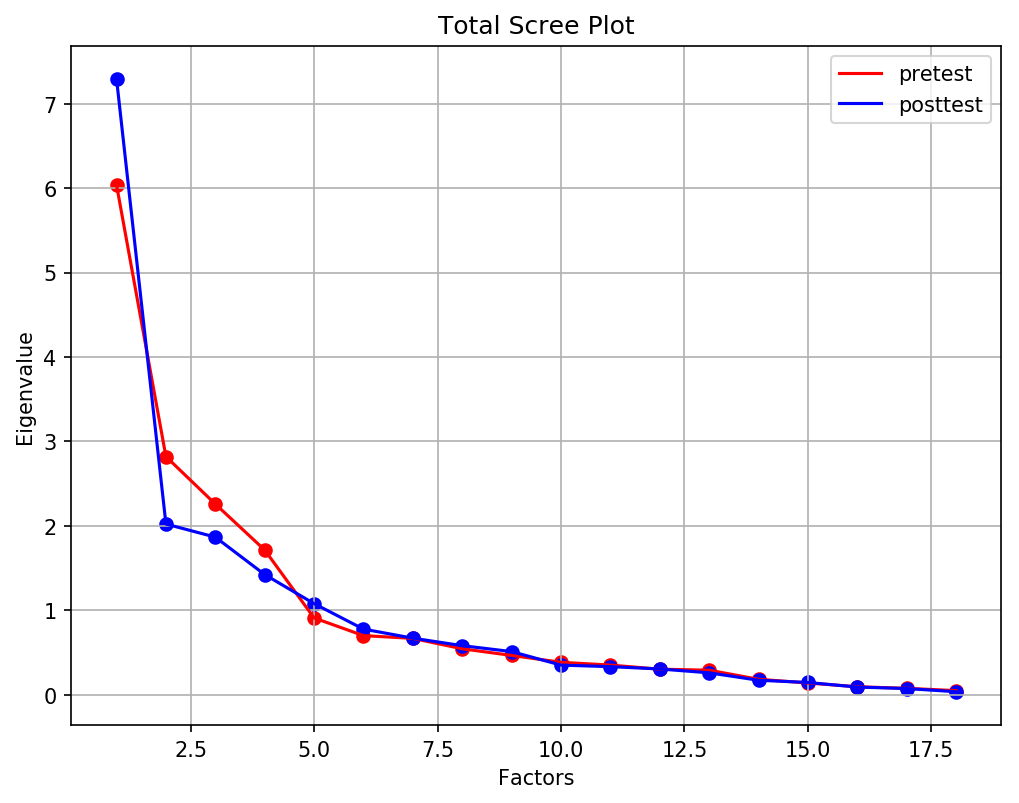

In [61]:
fapre = FactorAnalyzer(n_factors = pre_atti1_na.shape[1], rotation =None ).fit(pre_atti1_na)
ev1, v1 = fapre.get_eigenvalues()

fapost = FactorAnalyzer(n_factors = post_atti1_na.shape[1], rotation =None ).fit(post_atti1_na)
ev2, v2 = fapost.get_eigenvalues()


plt.figure(figsize = [8, 6], dpi = 150)
plt.scatter(range(1,18+1),ev1 , color='r')
plt.plot(range(1,18+1),ev1 , color='r', label='pretest')

plt.scatter(range(1,18+1),ev2 , color='b')
plt.plot(range(1,18+1),ev2 , color='b', label='posttest')

plt.title('Total Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.legend(loc='upper right')
plt.grid()
plt.show()




#### 前測 rotation =  varimax
#### 下面的結果 加上 上面的圖，可以得知 語言的因素比較重要

In [38]:
## varimax
fa = FactorAnalyzer(n_factors = 6, rotation ='varimax' ).fit(pre_atti1_na)

df = pd.DataFrame(fa.loadings_).transpose()
df.columns = pre_atti1_na.columns
df.to_csv('pre_varimax.csv', encoding='utf8')
df



,優美[C],優美[T],優美[E],親切[C],親切[T],親切[E],知識[C],知識[T],知識[E],趣味[C],趣味[T],趣味[E],領導[C],領導[T],領導[E],信任[C],信任[T],信任[E]
0,0.940535,0.034106,0.253246,0.898301,0.080583,-0.121974,0.730365,0.179348,0.112431,0.799694,0.054310,0.118433,0.307730,-0.116575,0.071049,0.350152,0.036982,0.047245
1,0.179330,0.594218,0.380459,0.057837,0.798965,-0.094993,0.335981,0.652169,0.597838,-0.020537,0.774296,0.070874,-0.000438,0.174284,0.249196,0.194073,0.251644,0.128844
2,0.110739,0.022875,0.071006,0.038585,0.040788,0.319144,-0.010000,0.133174,0.044765,0.120098,0.221850,0.067390,0.325962,0.344929,0.246623,0.741969,0.717307,0.619739
3,-0.019769,0.052448,-0.109827,-0.112100,-0.012512,-0.006426,0.228378,0.070462,0.248358,0.122676,0.030557,0.164426,0.839147,0.790093,0.353577,0.312604,0.302134,0.225950
4,0.086411,0.146937,0.589559,0.138454,-0.063630,0.739660,-0.068197,-0.000431,0.319859,0.030025,0.007015,0.732407,0.095593,0.053325,0.150190,0.121451,0.211491,0.400524
5,-0.022585,-0.000227,0.120006,0.050827,0.183183,0.060537,0.076364,0.026609,0.302712,0.016896,-0.018985,0.011382,0.201817,0.160264,0.852057,-0.051009,0.168174,0.280564


#### rotation 從 varimax 換成 promax 的整體結果並沒有大改變，所以因素負荷量都統一用 varimax 

In [ ]:
## promax
fa = FactorAnalyzer(n_factors = 6, rotation ='promax' ).fit(pre_atti1_na)

df = pd.DataFrame(fa.loadings_).transpose()
df.columns = pre_atti1_na.columns
df.to_csv('pre_promax.csv', encoding='utf8')
df


#### 後測 rotation =  varimax

In [40]:
## varimax
fa = FactorAnalyzer(n_factors = 6, rotation ='varimax' ).fit(post_atti1_na)

df = pd.DataFrame(fa.loadings_).transpose()
df.columns = post_atti1_na.columns
df.to_csv('post_varimax.csv', encoding='utf8')
df


,優美[C],優美[T],優美[E],親切[C],親切[T],親切[E],知識[C],知識[T],知識[E],趣味[C],趣味[T],趣味[E],領導[C],領導[T],領導[E],信任[C],信任[T],信任[E]
0,0.108707,0.292952,0.096847,0.203944,0.103084,0.174655,0.184544,0.272929,0.129560,0.317944,0.087622,0.065132,0.879653,0.764882,0.692446,0.428142,0.540995,0.613097
1,0.796102,0.209613,0.247322,0.872316,0.084017,0.254519,0.573558,-0.117037,0.143507,0.715189,0.084248,0.106222,0.397764,0.220979,0.093158,0.469609,0.081306,0.158754
2,-0.005627,0.262750,0.495009,0.039249,0.105997,0.367037,0.443536,0.473459,0.747262,0.448871,0.269499,0.836156,0.097724,0.109105,0.295435,0.090252,0.009201,0.182532
3,0.131040,0.137162,0.189626,0.194653,0.089983,0.491980,0.128984,0.161036,0.039867,0.068277,-0.005479,0.075851,0.141287,0.221842,0.151704,0.724223,0.503040,0.658747
4,0.205360,0.441252,0.209617,0.117197,0.854787,0.028114,0.015732,0.073848,0.082799,-0.115273,0.379982,0.130467,0.101038,0.018515,0.166995,0.121642,0.298472,0.132471
5,-0.030958,0.077367,-0.425543,-0.005278,0.154924,-0.191247,0.088098,0.321722,0.183214,-0.068786,0.831874,-0.003500,0.031134,0.149036,-0.087164,0.107100,0.080340,-0.036110


### 語言分開
 - 因為有 顯性、隱性 之分，所以先看是否分成 2個 因素數目

看前測，分成 2個 因素數目看起來是 OK 的

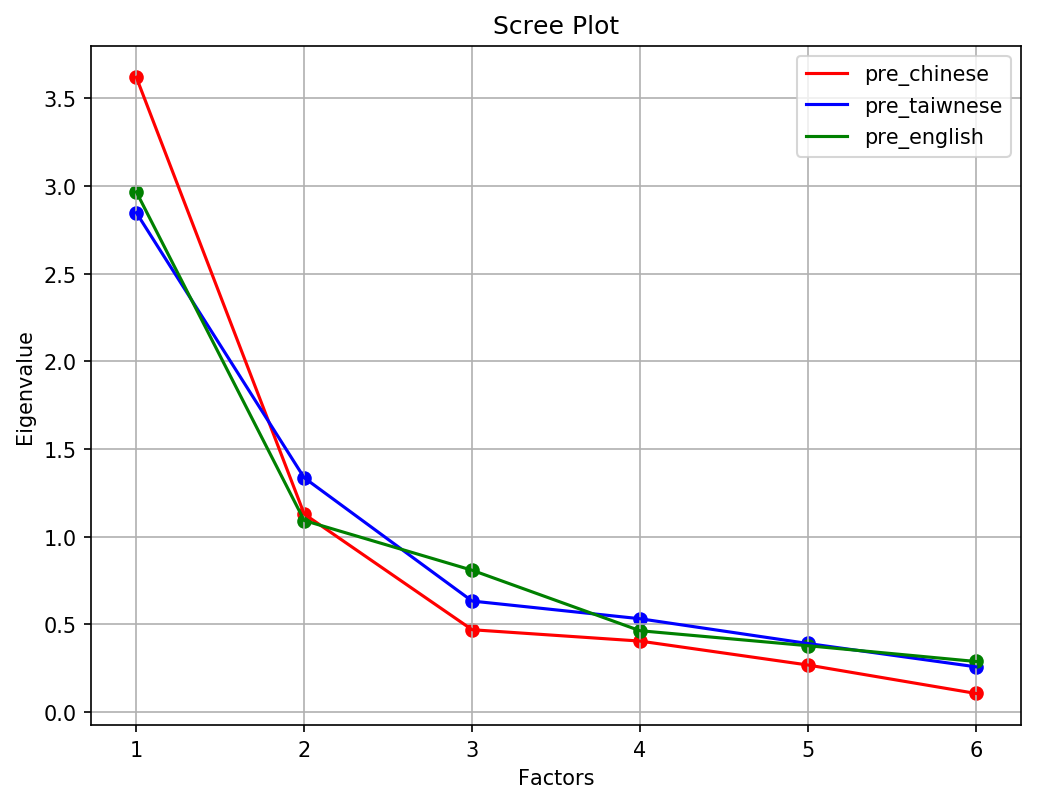

In [62]:
fac = FactorAnalyzer(n_factors = pre_atti1_c_na.shape[1], rotation =None ).fit(pre_atti1_c_na)
ev1, v1 = fac.get_eigenvalues()

fat = FactorAnalyzer(n_factors = pre_atti1_t_na.shape[1], rotation =None ).fit(pre_atti1_t_na)
ev2, v2 = fat.get_eigenvalues()

fae = FactorAnalyzer(n_factors = pre_atti1_e_na.shape[1], rotation =None ).fit(pre_atti1_e_na)
ev3, v3 = fae.get_eigenvalues()


plt.figure(figsize = [8, 6], dpi = 150)
plt.scatter(range(1,6+1),ev1 , color='r')
plt.plot(range(1,6+1),ev1 , color='r', label='pre_chinese')

plt.scatter(range(1,6+1),ev2 , color='b')
plt.plot(range(1,6+1),ev2 , color='b', label='pre_taiwnese')

plt.scatter(range(1,6+1),ev3 , color='g')
plt.plot(range(1,6+1),ev3 , color='g', label='pre_english')

plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.legend(loc='upper right')
plt.grid()
plt.show()



In [25]:
fa = FactorAnalyzer(n_factors = 2, rotation = 'varimax' ).fit(pre_atti1_c_na)

df = pd.DataFrame(fa.loadings_).transpose()
df.columns = pre_atti1_c_na.columns
df


,優美[C],親切[C],知識[C],趣味[C],領導[C],信任[C]
0,0.944332,0.863158,0.671776,0.741940,0.128298,0.313071
1,0.195367,0.141458,0.301213,0.288628,0.991267,0.588552


In [26]:
fa = FactorAnalyzer(n_factors = 2, rotation = 'varimax' ).fit(pre_atti1_t_na)

df = pd.DataFrame(fa.loadings_).transpose()
df.columns = pre_atti1_t_na.columns
df


,優美[T],親切[T],知識[T],趣味[T],領導[T],信任[T]
0,0.567790,0.829447,0.646266,0.805447,0.102361,0.200859
1,0.115352,0.044131,0.166256,0.186333,0.666584,0.861064


In [27]:
fa = FactorAnalyzer(n_factors = 2, rotation = 'varimax' ).fit(pre_atti1_e_na)

df = pd.DataFrame(fa.loadings_).transpose()
df.columns = pre_atti1_e_na.columns
df


,優美[E],親切[E],知識[E],趣味[E],領導[E],信任[E]
0,0.546053,0.693502,0.308922,0.760872,0.083148,0.475456
1,0.287935,0.142477,0.541618,0.152125,0.994073,0.505896


### 語言分開
 - 因為有 顯性、隱性 之分，所以看是否分成 2個 因素數目

看後測，分成 2個 因素數目看起來也是 OK 的

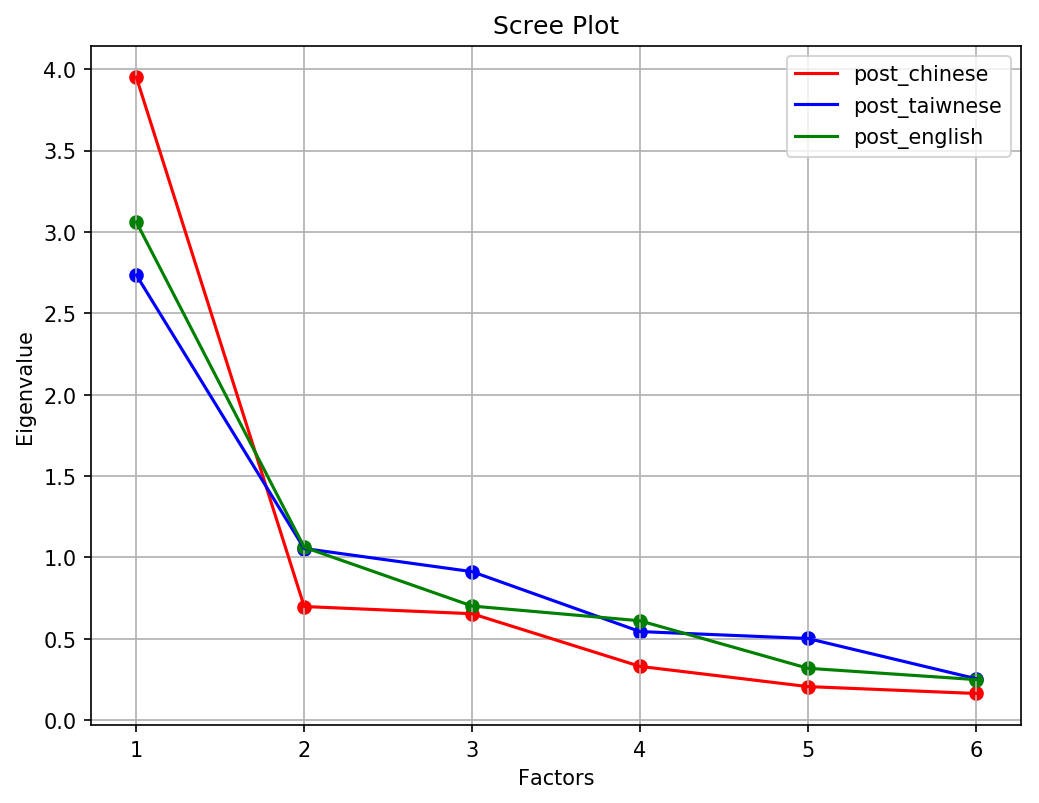

In [63]:
fac = FactorAnalyzer(n_factors = post_atti1_c_na.shape[1], rotation =None ).fit(post_atti1_c_na)
ev1, v1 = fac.get_eigenvalues()

fat = FactorAnalyzer(n_factors = post_atti1_t_na.shape[1], rotation =None ).fit(post_atti1_t_na)
ev2, v2 = fat.get_eigenvalues()

fae = FactorAnalyzer(n_factors = post_atti1_e_na.shape[1], rotation =None ).fit(post_atti1_e_na)
ev3, v3 = fae.get_eigenvalues()



plt.figure(figsize = [8, 6], dpi = 150)
plt.scatter(range(1,6+1),ev1 , color='r')
plt.plot(range(1,6+1),ev1 , color='r', label='post_chinese')

plt.scatter(range(1,6+1),ev2 , color='b')
plt.plot(range(1,6+1),ev2 , color='b', label='post_taiwnese')

plt.scatter(range(1,6+1),ev3 , color='g')
plt.plot(range(1,6+1),ev3 , color='g', label='post_english')

plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.legend(loc='upper right')
plt.grid()
plt.show()





In [28]:
fa = FactorAnalyzer(n_factors = 2, rotation = 'varimax' ).fit(post_atti1_c_na)

df = pd.DataFrame(fa.loadings_).transpose()
df.columns = post_atti1_c_na.columns
df


,優美[C],親切[C],知識[C],趣味[C],領導[C],信任[C]
0,0.299063,0.576448,0.694556,0.780225,0.715968,0.668316
1,0.952488,0.665009,0.257085,0.337247,0.238339,0.357842


In [29]:
fa = FactorAnalyzer(n_factors = 2, rotation = 'varimax' ).fit(post_atti1_t_na)

df = pd.DataFrame(fa.loadings_).transpose()
df.columns = post_atti1_t_na.columns
df


,優美[T],親切[T],知識[T],趣味[T],領導[T],信任[T]
0,0.429681,0.322550,0.309994,0.059942,0.571630,0.945123
1,0.379089,0.479207,0.385819,0.998521,0.201767,0.123635


In [30]:
fa = FactorAnalyzer(n_factors = 2, rotation = 'varimax' ).fit(post_atti1_e_na)

df = pd.DataFrame(fa.loadings_).transpose()
df.columns = post_atti1_e_na.columns
df


,優美[E],親切[E],知識[E],趣味[E],領導[E],信任[E]
0,0.388321,0.484517,0.190786,0.191019,0.601836,1.000654
1,0.430791,0.380568,0.673221,0.928845,0.265915,0.097956
